# P219 Problem Set 2

This notebook reproduces the code for P219 Problem Set 2. The questions in this problem set are based on [Killian (2009)](https://www.aeaweb.org/articles?id=10.1257/aer.99.3.1053) and use a `.mat` data provided by the course TA.

We begin by importing the necessary libraries and organizing the the data in `Kilian_Data_Updated.mat`.

In [ ]:
# Import necessary packages
using MAT, Plots, LinearAlgebra, # DataFrames, StatsPlots

# Default plot parameters
default(legend = false)
default(titlefontsize = 8)
default(xlabelfontsize = 6)
default(ylabelfontsize = 6)

# Read .mat file and save as variable
fileIn = matopen("./data/Kilian_Data_Updated.mat")
mat_file = read(fileIn)
close(fileIn);

Now that we have the data, we can start by plotting the variables in a figure with three panels: one for each variable in the `mat_file["varNames"]`.

In [ ]:
# Initiate a 3 by 1 plot graph given specifications
p = plot(layout=(3,1), size=(800,800))

# Loop over number of variables
for i in 1:size(mat_file["varNames"])[2]
    # Include horizontal line at value 0
    hline!(p[i], [0], linestyle=:d, color=:gray)
    # Append graph and include name according to index
    plot!(p[i], mat_file["data"][:, i:i],
          title=mat_file["varNames"][i], color=:purple)
end

# Save plot
savefig(p,"images/var_plots.png")

# Display plot
display(p)

Need to add reasoning for recursive identification in the form of:

\begin{align*}
    \textbf{u}_t = \begin{pmatrix}
                   u_t^1 \\
                   u_t^2 \\
                   u_t^3
                   \end{pmatrix} = \begin{pmatrix}
                   a_{11} & 0 & 0 \\
                   a_{21} & a_{22} & 0 \\
                   a_{31} & a_{32} & a_{33}
                   \end{pmatrix} \begin{pmatrix} 
                                  \varepsilon_t^1 \\ 
                                  \varepsilon_t^2 \\
                                  \varepsilon_t^3
                                 \end{pmatrix}
\end{align*}

Include text justification here.

<p>&nbsp;</p>

### 1.1 Estimating the reduced form VAR

The next step in our analysis is to estimate a reduced form VAR given the data we have available. Write summary of what the function is supposed to do.

In [3]:
# Define var_ols function
function var_ols(data, constant, p)
    """
    This function uses OLS to calculate the estimators of a VAR regression. It creates matrices
    based on the how many lags the user wants to use for the regression and whether a constant
    term should be added or not. The results of the regression are the output of this function.
    
    Inputs
    ------
        data      : a Matrix with the data to be used
        constant  : a boolean determining whether the function should use a constant
        p         : an integer with the number of lags in the VAR
    
    Output
    ------
        results   : a tuple containing matrices B ,Σ and u which are, respectively the OLS
                    estimates of the VAR regression, the variance-covariance matrix and the
                    matrix of error terms of the regression
    
    """
    # Retrieve number of rows and columns of matrix data as tuple of ints
    r, n = size(data)::Tuple{Int64, Int64}
    # Assign variable as number of rows in final data matrix
    t = Int(r-p)
    # Create matrix structure for dependent variables
    Y = data[p+1:r, :]
    # Build matrix with lagged values including leading 1 for constants
    X = ones(t, 1)
    # Loop over p lags to build X matrix with lags
    for i in 1:p
        X = [X data[p+1-i:r-i,:]]
    end
    # If no constant, exclude leading column of ones
    if constant == false
        X = X[:, 2:size(X)[2]]
    end
    # Calculate B matrix as OLS given data matrix X and matrix Y
    B = (X'*X)\(X'*Y)
    # Calculate errors given estimated B
    u = Y - X*B
    # Estimate Σ as variance-covariance matrix
    Σ = (u'*u/r)
    # Return tuple with matrix B and Σ
    return (B, Σ, u)
end

# Apply function to p = 12 lags
results = var_ols(mat_file["data"], true, 12);

### 1.2. Obtaining $\textbf{A}_0$

Now that we have the reduced form estimates of $\textbf{B}$ and $\textbf{Σ}$, we can use the lower Cholesky decomposition to obtain the structural impact matrix $\textbf{A}_0$. By taking the Cholesky decomposition we get $\operatorname{chol}(\textbf{Σ}) = \textbf{A}_0^{-1}$, so we can invert the result of the decomposition in order to get the matrix $\textbf{A}_0$.

In [4]:
# Calculate the invers of A0 using lower-triangular Cholesky decomposition
A0_inverse = cholesky(results[2]).L
# Invert result to get A0 matrix
A0 = inv(A0_inverse);

### 1.3. Computing the Impulse Response Functions

We now write a function that computs the Inpulse Response Functions. In order to do that, we can apply the formula:

\begin{align*}
    \textbf{L}_h (\Theta) = \left( (\textbf{A}_0')^{-1} \textbf{J}' \textbf{F}^h \textbf{J}\right)'
\end{align*}

To the matrices we have already calculated. Above we have that $\textbf{F}$ is our companion matrix, which in this case have dimensions $36 \times 36$. The matrix $\textbf{J} = [\textbf{I}_n \qquad \textbf{0}_{n \times n \cdot (p-1)}]'$. The $(i, j, h)$ entry of the IRF matrix $\textbf{L}_h (\Theta)$ is the impact of shock $j$ on variable $i$ at horizon $h$. The function below also allows us to cumulate the shock by passing a vector `cumulateWhich` which determines whether a positive or negative shock should be cumulated.

In [5]:
# Define irf function
function irf(B, A0, constant, hmax, cumulateWhich)
    """
    This function calculates the IRF given parameters. In order to do that it uses the formula
    stated in the description above. The final output of the function is a three dimensional
    object as specified in the description below.
    
    Inputs
    ------
        B              : a Matrix with p*n +1 rows and n columns representing the estimators of the
                         OLS regression of the VAR
        A0             : a Matrix with n rows and n columns that is obtained by the lower-triangular
                         Cholesky decomposition of the errors of the regression
        constant       : a boolean where true if constant was used to compute B and false
                         otherwise
        hmax           : an integer with the maximum number of h-periods ahead to calculate IRF
        cumulateWhich  : a vector where value 1 of index i indicates cumulative sum of variable i
                         and other values indicate that cumulative sum should not be taken
    Output
    ------
        IRF            : a Matrix that is n x n x n where the (i, j, j) entry represents the impact
                         of shock j on variable i at horizon h
    
    """
    # Get size of matrix A0
    q, n = size(B)
    # Calculate p lags based on size of B
    p = Int((q-1)/n)
    # Create J matrix
    J = [I(n) zeros(n, n*(p-1))]'
    # If constant true skip first column of B when creating F
    if constant == true
        # Create companion matrix
        F = [B[2:q,:]'; [I(n*(p-1)) zeros(n*(p-1), n)]]
    # Otherwise do not skip first row for F
    else
        F = [B[1:q,:]'; [I(n*(p-1)+1) zeros(n*(p-1)+1, 3)]]
    end
    # Define three dimensional matrix IRF to hold IRFs
    IRF = zeros(n, n, hmax+1)
    # Loop over hmax times to get IRF at time h
    for h in 0:hmax
        IRF[:, :, h+1] = (A0\J'*(F^h)*J)
    end
    # Check vector cumulateWhich for cumulated IRF variables and sign
    for j in eachindex(cumulateWhich)
        # If value is 1 cumulate IRF
        if cumulateWhich[j] == 1
            IRF[j, :, :] = cumulateWhich[j]*cumsum(IRF[j,:,:], dims=2)
        end
    end
    # Return IRF three dimensional matrix
    return IRF
end


# Use formula to obtain IRF function
IRF = irf(results[1], A0, true, 24, [1 0 0])

# Multiply first column over all horizons to make shock to oil p
IRF[:, 1:1, :] = -1*IRF[:, 1:1, :];

Now that we have calculated the IRF function, we can then create a $3 \times 3$ plot of the IRFs.

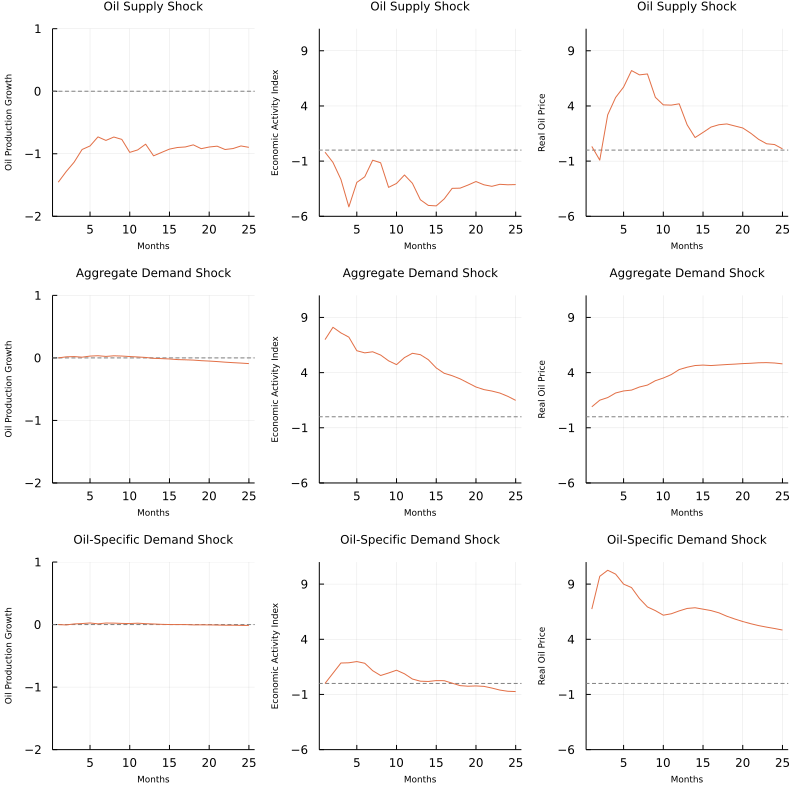

In [6]:
# Initiate plots according to specification
p = plot(layout=(3,3), size=(800,800))

# Loop over variables
for i in 1:size(IRF)[1]
    # And loop over shocks
    for j in 1:size(IRF)[2]
        # Select name of shock according to index
        if j == 1
            shock = "Oil Supply Shock"
        elseif j == 2
            shock = "Aggregate Demand Shock"
        else
            shock = "Oil-Specific Demand Shock"
        end
        # Adjust tick based on variable
        if i == 1
            yticks = (-2:1:1)
            ylims = (-2,1)
        else i == 2
            yticks = (-6:5:11)
            ylims = (-6, 11)
        end
        # Add line at y = 0
        hline!(p[j,i], [0], linestyle=:d, color=:gray)
        # Append plot to major plots according to index
        plot!(p[j,i], IRF[i,j,:], legend=false,
            title=string(shock),
            xlabel="Months",
            yticks=yticks,
            ylims=ylims,
            ylabel=mat_file["varNames"][i])
    end
end

# Save plot
savefig(p,"images/irf_plots.png")

# Display plots
display(p)

### 1.4 Obtaining the time series of shocks

The next step is to create a function that outputs the shocks. In order to do that, we need to compute the reduced-form innovation $\textbf{u}_t$ and use the matrix $\textbf{A}_0$ to obtain the structural shocks. In this paper, we are assuming that $\textbf{u}_t$ can be decomposed according to $\textbf{u}_t = \textbf{A}_0^{-1} \varepsilon_t$, such that

\begin{align*}
    \textbf{u}_t = \begin{pmatrix}
                    u_t^{\Delta_{prd}} \\
                    u_t^{\Delta_{rea}} \\
                    u_t^{\Delta_{rpo}}
                    \end{pmatrix} = \begin{pmatrix}
                    a_{11} & 0 & 0 \\
                    a_{21} & a_{22} & 0 \\
                    a_{31} & a_{32} & a_{33}
                    \end{pmatrix} \begin{pmatrix}
                    \varepsilon_t^{\Delta_{OS}} \\
                    \varepsilon_t^{\Delta_{AD}} \\
                    \varepsilon_t^{\Delta_{SD}}
                    \end{pmatrix}
\end{align*}

This means that we can retrieve the structural shocks by using the matrices we have calculated so far. Given that we already have $\textbf{u}_t$ as an output of the function `var_ols` and the matrix $\textbf{A}_0$ from the Cholesky decomposition, we can easily write a formula to compute the structural errors.

In [7]:
# Define function to retrieve structural shocks
function get_shocks(u, A0)
    """
    This function retrieves the structural shocks from the reduced form VAR. In order to
    do that it assumes that the A0 is lower-triangular and uses the parameters to compute
    the shocks.
    
    Inputs
    ------
        u   : a Matrix with T - p rows and n columns with the errors from the OLS of the
              data on Y
        A0  : a Matrix with n rows and n columns that is obtained by the lower-triangular
              Cholesky decomposition of the errors of the regression
    
    Output
    ------
        ε   : a Matrix with n rows and T - p columns with the structural shocks of the model
    
    """  
    # Calculate structural shocks
    ε = A0 * u'
    # Return structural shock
    return ε
end


# Calculate the structural shocks
ε = get_shocks(results[3], A0)

3×528 Matrix{Float64}:
  0.875956   0.644562  -0.577652  …  -0.0294886   0.0444611  -0.947745
 -1.82803   -2.31087   -0.438903     -0.542363   -2.98431    -0.690279
  0.535056   0.772542   0.21118       0.681951   -0.420945   -1.40474

We can then plot the shocks over time.

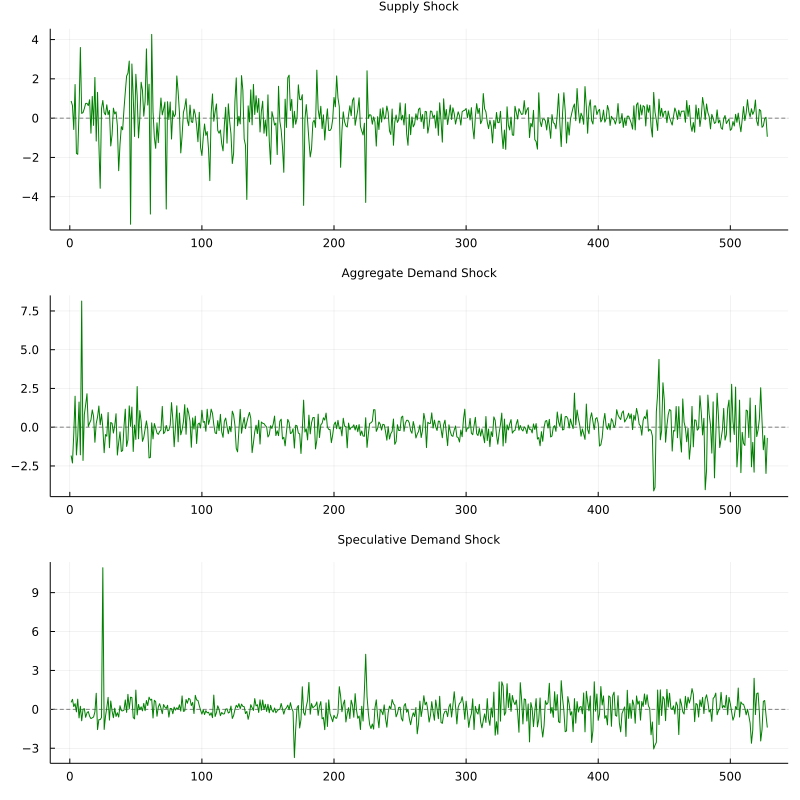

In [8]:
# Initiate plot according to specifications
p = plot(layout=(3,1), size=(800,800))

# Loop over structural shocsk
for i in 1:size(ε)[1]
    # Define title based on index
    if i == 1
        shock_tl = "Supply Shock"
    elseif i == 2
        shock_tl = "Aggregate Demand Shock"
    else
        shock_tl = "Speculative Demand Shock"
    end
    # Add horizontal line at y = 0
    hline!(p[i], [0], linestyle=:d, color=:gray)
    # Append graph to major plot
    plot!(p[i], ε[i:i,:]',
          title=shock_tl, color=:green)
end

# Save plot
savefig(p,"images/shocks_plots.png")

# Display plot
display(p)

Add some more about historical observations

<p>&nbsp;</p>

### 1.5. Obtainint the Forecast Error Variance Decomposition

Next, we write a function called `get_fevd` that computes the Forecast Error Variance Decomposition. In order to do that, we use the formula:

\begin{align*}
    \operatorname{FEVD}_k = \frac{\sum_{h=0}^k \textbf{L}_h (\Theta)^2}{\sum_{j=1}^n \sum_{h=0}^k \textbf{L}_h (\Theta)^2}
\end{align*}

Where $\textbf{L}_h (\Theta)$ is the IRF matrix that we have computed in section 1.3. The output of the function will be a $n \times n \times \text{hmax} +1$ matrix.

In [9]:
# Define function to calculate FEVD
function fevd(IRF, hmax)
    """
    Description
    
    Inputs
    ------
        IRF  : a Matrix that is n x n x n where the (i, j, j) entry represents the impact
               of shock j on variable i at horizon h
        hmax : an integer with the number of h-periods ahead to calculate the FEVD
    
    Outputs
    -------
        FEVD : a Matrix that is n x n x hmax + 1 where the entry (i, j, h) is the FEVD for shock
               j on variable h at horizon h
    
    """
    # Get size of IRF matrix
    n, t, q = size(IRF)  
    # Define three dimensional matrix FEVD to hold FEVDs and MSE
    MSE = zeros(n, hmax+1)
    FEVD = zeros(n, n, hmax+1)
    # Loop over hmax times to get IRF at time h
    for h in 0:hmax
        # Get MSE matrix given data
        MSE[:, h+1] = sum(sum(IRF[:, :, 1:h+1].^2, dims=3), dims=2)
        # Calculate FEDV using formula
        FEVD[:, :, h+1] = sum(IRF[:, :, 1:h+1].^2, dims=3)./repeat(MSE[:, h+1:h+1], 1, n)
    end
    # Return FEVD as three dimensional object
    return FEVD
end


# Create variablee to hold FEVDs
FEVD = fevd(IRF, 24);

We can then plot a bar chart for each shock and each variable over time in order to decompose the forecast variance of each variable.

In [10]:
#plot_matrix = zeros(size(FEVD)[3]-1, size(FEVD)[1])

#for h in 1:size(FEVD)[3]-1
#    plot_matrix[h, :] = FEVD[2:2, :, h]
#end

p = bar(layout=(1,3), size=(800,500))

for i in 1:3
    b = bar()
    
    plot_matrix = zeros(size(FEVD)[3]-1, size(FEVD)[1])

    for h in 1:size(FEVD)[3]-1
        plot_matrix[h, :] = FEVD[i:i, :, h]
    end
    groupedbar!(reverse(plot_matrix, dims=2), bar_position = :stack)
    
end

In [11]:
bar(reverse(plot_matrix, dims=2), bar_position=:stacked, bar_width=1, title = plot_info[1], lw=0.1)

LoadError: UndefVarError: plot_matrix not defined

In [12]:
mat_file["varNames"]

1×3 Matrix{Any}:
 "Oil Production Growth"  "Economic Activity Index"  "Real Oil Price"

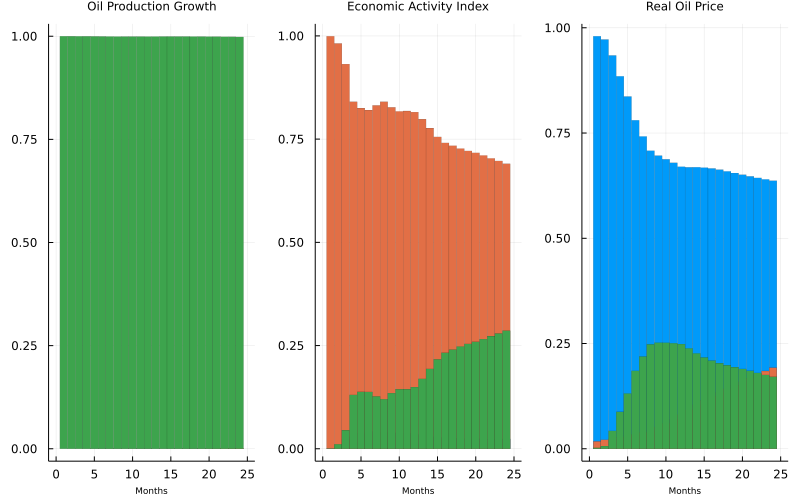

┌ Warning: Keyword argument bar_position not supported with Plots.GRBackend().  Choose from: Set([:top_margin, :group, :inset_subplots, :background_color, :ytickfontsize, :yforeground_color_text, :yguidefontcolor, :tickfontfamily, :show_empty_bins, :seriesalpha, :seriescolor, :ztick_direction, :xgrid, :ygridalpha, :zlims, :xtick_direction, :colorbar, :legend_font_family, :zflip, :ticks, :linealpha, :overwrite_figure, :arrow, :xguidefonthalign, :normalize, :linestyle, :xtickfontvalign, :xflip, :zgrid, :fillcolor, :ygrid, :bar_width, :colorbar_scale, :background_color_inside, :zguidefonthalign, :bins, :zguide, :zforeground_color_text, :legend_font_valign, :yscale, :legend_font_color, :weights, :xgridalpha, :ygridstyle, :clims, :xtickfontcolor, :fill_z, :xguide, :markershape, :background_color_subplot, :ztickfontfamily, :fillalpha, :markerstrokewidth, :tick_direction, :xguidefontvalign, :xguidefontfamily, :gridlinewidth, :foreground_color_subplot, :xgridlinewidth, :yguidefontsize, :foregr

In [13]:
b = bar(layout=(1,3), size=(800,500), xlabel="Months")

for i in 1:size(FEVD)[1]
    # Initiate matrix to hold data for plot
    plot_matrix = zeros(size(FEVD)[3]-1, size(FEVD)[1])
    # Loop over h-periods and get plot data in FEDV
    for h in 1:size(FEVD)[3]-1
        plot_matrix[h, :] = FEVD[i:i, :, h]
    end
    # Define tuple to hold title and plot data conditional on index
    #if i == 1
    #    plot_info = ("Economic activity index", reverse(plot_matrix, dims=2))
    #elseif i == 2
    #    this
    #else
    #    this
    #end
    
    # Define tuple to hold title and plot data
    plot_info = (mat_file["varNames"][i], reverse(plot_matrix, dims=2))
    # Append graph and title in major plot
    bar!(b[i], plot_info[2], bar_position=:stack, bar_width=1, title = plot_info[1], lw=0.1)
    
end

# Save plot
savefig(p,"images/fevd_plots.png")

# Show plot
display(b)

In [14]:
using Pkg

Pkg.status("Plots")

      Status `C:\Users\gsimoesgaspar\.julia\environments\v1.6\Project.toml`
  [91a5bcdd] Plots v1.25.10


### 1.6. Obtaining the Historical Decompositions

The historical decomposition shows us the cumulative contribution of each shock to the observed unexpected change in the variable between periods. We can calculate the constribution of the $j$-th shock to the observed unexpected change in the $i$-th variable between periods $t$ and $t+h$ as:

\begin{align*}
    H_{i, j, t, t+h}(\Theta, \varepsilon_t, \cdots, \varepsilon_{t+h}) = \sum_{\ell = 0}^h \textbf{e}_{i,n}' \textbf{L}_\ell (\Theta) \textbf{e}_{j,n} \textbf{e}_{j,n}' \varepsilon_{t+h - \ell}
\end{align*}

Where $\textbf{e}_{j,n}$ is the $j$-th column of the indentity matrix $\textbf{I}_n$ for $1 \leq i, j \leq n$ and for $h \geq 0$. This allows us to track at each point in time the role of a structural shock in driving the VAR's endogenous variables away from their steady state. Given the formula above, we can write a formula to calculate the historical decomposition.

In [15]:
# Define function to calculate historical decomposition
function get_hd(IRF, n, ε, whichVariable)
    """
    This function calculates the historical decomposition given parameters.
    In order to do that it uses the formula cited in the text above. It
    returns the sum over a certain period, which can be interpreted as how
    much one shock explains the value of the variable of interest
    
    Inputs
    ------
        IRF           : a Matrix that is n x n x n where the (i, j, j) entry represents the impact
                        of shock j on variable i at horizon h
        n             : an integer with the number of variables to be looked at
        ε             : a Matrix with the structural shocks over time as columns and the shocks as rows
        whichVariable : an integer with the index of the variable to be looked at
    
    Output
    ------
        HD            : a vector with the HD decomposition for a given variable at a certain time horizon
    
    """
    # Get maximum time horizon minus one to index 0
    hmax = size(ε)[2]-1
    # Create identity matrix given n
    Ident = I(n)
    # Define matrix to hold historical decomposition results
    HD = zeros(n, hmax+1)
    # Loop over h times with zero indexing
    for h in 0:hmax
        # Loop over variables
        for j = 1:n
            # Calculate HD using formula
            HD_sum = Ident[:, whichVariable:whichVariable]'*IRF[:, :, h+1]*Ident[:, j:j]*Ident[:, j:j]'*ε[:, end-h:end-h]
            # Result is 1x1 matrix so take only observation and set in HD
            HD[j, h+1] = HD_sum[1]
        end
    end
    # Return sum over columns of HD 
    return sum(HD, dims=2)
end


# Create IRF for T-p periods
IRFs = irf(results[1], A0, true, size(ε)[2]-1, [0 0 0])

# Set number of shocks to be calculated
whichVariable = 3

# Initiate variable to store all values
HD_store = zeros(size(ε))

# Loop over all time horizons and calculate HD given parameters
for t in 1:size(ε)[2]
    HD_store[:, t] = get_hd(IRFs[:,:,1:t], 3, ε[:, 1:t], whichVariable)
end

Finally, we can plot the result of the historical decomposition function of real price of oil into the contributions of the three structural shocks that we looked at. 

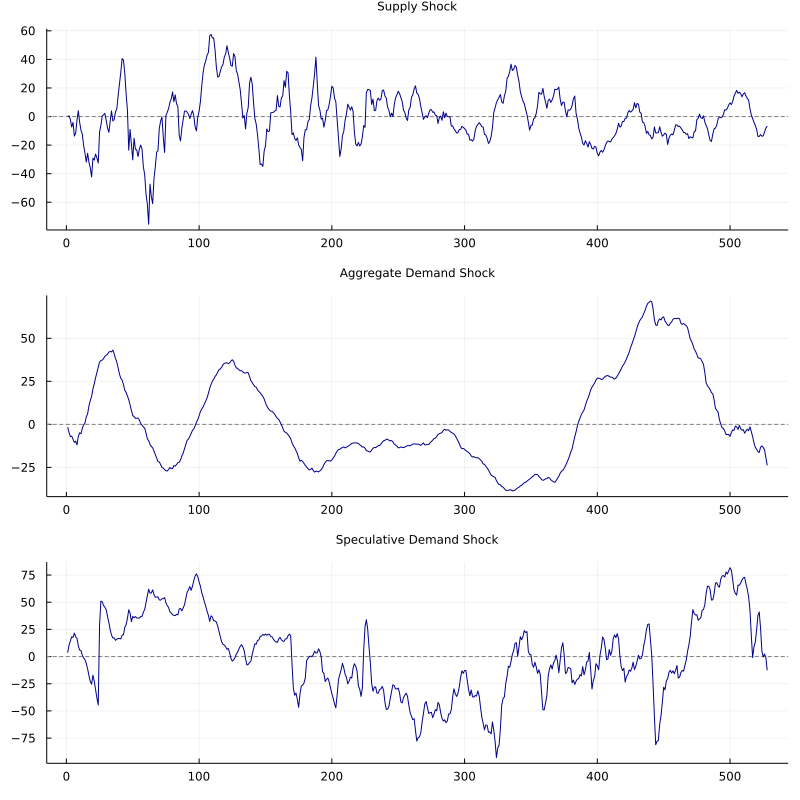

In [16]:
# Initiate plot according to specifications
p = plot(layout=(3,1), legend=false, size=(800,800),
        titlefontsize=8, xlabelfontsize=6, ylabelfontsize=6)

# Loop over structural shocsk
for i in 1:size(HD_store)[1]
    # Define title based on index
    if i == 1
        shock_tl = "Supply Shock"
    elseif i == 2
        shock_tl = "Aggregate Demand Shock"
    else
        shock_tl = "Speculative Demand Shock"
    end
    # Add horizontal line at y = 0
    hline!(p[i], [0], linestyle=:d, color=:gray)
    # Append graph to major plot
    plot!(p[i], HD_store[i:i,:]', legend=false,
          title=shock_tl, color=:darkblue)
end

# Save plot
savefig(p,"images/hd_plots.png")

# Display plot
display(p)